In [1694]:
#!g1.1
import numpy as np 
import pandas as pd
import math
# import matplotlib.pyplot as plt

import glob
from PIL import Image
from copy import deepcopy

from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel, SWALR

from tqdm import tqdm, trange
import random
from collections import defaultdict
from IPython.display import clear_output

import pytorch_fid
from pytorch_fid import *
from pytorch_fid.fid_score import calculate_fid_given_paths

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# %matplotlib inline

In [1492]:
#!g1.1
%pip install torch==1.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 2041.3 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.7.0 requires torch==1.6.0, but you have torch 1.9.1+cu111 which is incompatible.
mmdet 2.3.0rc0+c6b5ca2 requires Pillow<=6.2.2, but you have pillow 8.4.0 which is incompatible.
mmdet 2.3.0rc0+c6b5ca2 requires torch==1.6.0, but you have torch 1.9.1+cu111 which is incompatible.
enot-utils 1.0.2 requires torch==1.6.0, but you have torch 1.9.

In [1475]:
#!g1.1
%pip install pytorch-fid

Defaulting to user installation because normal site-packages is not writeable
  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.1-py3-none-any.whl size=14818 sha256=c24c8faf18b6f350039d4a96adb76379059c951a7d9141c34b8c20794e815b1d
  Stored in directory: /tmp/xdg_cache/pip/wheels/24/ac/03/c5634775c8a64f702343ef5923278f8d3bb8c651debc4a6890
Successfully built pytorch-fid
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [1495]:
#!g1.1
%pip install pandas==1.3.3

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.3 MB 2.2 MB/s 
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [1735]:
#!g1.1
import zipfile 
import tarfile

tar = tarfile.open('cityscapes.tar.gz', "r")
tar.extractall()
tar.close()
with zipfile.ZipFile('facades.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [1845]:
#!g1.1
IMG_SIZE = 256
BATCH_SIZE = 16

In [1846]:
#!g1.1
trans_im2tens = transforms.ToTensor()
trans_tens2im = transforms.ToPILImage()
trans_norm = transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                      std = [ 0.229, 0.224, 0.225 ])
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
                               
def get_dataset(mode='train', dataset='facades'):
    assert mode in ['train', 'val', 'test']
    assert dataset in ['facades', 'cityscapes']
    
    path_train = dataset + '/' + mode + '/*.jpg'
    
    X_train_in = []
    X_train_out = []

    for image in glob.glob(path_train):
        
        double_im=Image.open(image)
        tens = trans_im2tens(double_im)

        out_img = tens[:, :, :(tens.shape[2] // 2)]
        in_img = tens[:, :, (tens.shape[2] // 2):]

        X_train_in.append(trans_norm(in_img))
        X_train_out.append(trans_norm(out_img))
    
    return list(zip(X_train_in, X_train_out))

# def show_image(batch, num=3):
#     num = min(len(batch), num)
#     for tens in batch[:num]:
#         plt.imshow(trans_tens2im(inv_normalize(tens)))
#         plt.show()
    
# def show_paired(batch_in, batch_out, num=3):
#     assert len(batch_in) == len(batch_out)
#     num = min(len(batch_in), num)
#     for tens_in, tens_out in zip(batch_in[:num], batch_out[:num]):
#         catted = torch.cat((inv_normalize(tens_in), inv_normalize(tens_out)), dim=-1).detach()
#         plt.imshow(trans_tens2im(catted))
#         plt.show()

def fid(mode='train', facades=True):
    assert mode in ['train', 'val', 'test']
    path_to = ''
    if not facades:
        path_to = 'cityscapes/'
    path_real = 'predictions/' + path_to + mode + '/real'
    path_fake = 'predictions/' + path_to + mode + '/fake'
    
    paths = (path_real, path_fake)
    
    return calculate_fid_given_paths(paths=paths, batch_size=32, device=DEVICE, dims=2048)

# saves predictions to compute FID on them
def save_predictions(num_of_batch, batch1, batch2=None, dataset='train', facades=True):
    assert dataset in ['train', 'val', 'test']
    path_to = ''
    if not facades:
        path_to = 'cityscapes/'
    path_real = 'predictions/' + path_to + dataset + '/real'
    path_fake = 'predictions/' + path_to + dataset + '/fake'
    if batch2 is None:
        for i, tens1 in enumerate(batch1):
            name = '/' + str(BATCH_SIZE * num_of_batch + i) + '.bmp'
            im1 = trans_tens2im(inv_normalize(tens1))
            im1.save(path_fake + name)
    else:
        for i, (tens1, tens2) in enumerate(zip(batch1, batch2)):
            name = '/' + str(BATCH_SIZE * num_of_batch + i) + '.bmp'
            im1 = trans_tens2im(inv_normalize(tens1))
            im2 = trans_tens2im(inv_normalize(tens2))
            im1.save(path_real + name)
            im2.save(path_fake + name)


In [1847]:
#!g1.1
# если хотим ситискапес
torch.backends.cudnn.enabled = False
train_loader = torch.utils.data.DataLoader(dataset=get_dataset(dataset='cityscapes'), batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=get_dataset('val', dataset='cityscapes'), batch_size=BATCH_SIZE, shuffle=False)
# train_loader = torch.utils.data.DataLoader(dataset=get_dataset(), batch_size=BATCH_SIZE, shuffle=False)
# val_loader = torch.utils.data.DataLoader(dataset=get_dataset('val'), batch_size=BATCH_SIZE, shuffle=False)

/kernel/lib/python3.7/site-packages/ml_kernel/ignored_keyboard_interrupt.py:16: UserWarning: Kernel cannot be interrupted during state load
  warnings.warn(self._warn_message)


In [1793]:
#!g1.1
# верные ответы для подсчета FID
for i, (a, b) in enumerate(train_loader):
    save_predictions(i, b, a, dataset='train', facades=False)
for i, (a, b) in enumerate(val_loader):
    save_predictions(i, b, a, dataset='test', facades=False)

In [1723]:
#!g1.1
# Если хотим фасады
# torch.backends.cudnn.enabled = False
# train_loader = torch.utils.data.DataLoader(dataset=get_dataset(), batch_size=BATCH_SIZE, shuffle=False)

# val_loader = torch.utils.data.DataLoader(dataset=get_dataset('val'), batch_size=BATCH_SIZE, shuffle=False)
# test_loader = torch.utils.data.DataLoader(dataset=get_dataset('test'), batch_size=BATCH_SIZE, shuffle=False)

In [1848]:
#!g1.1
# discriminator class
class DiscriminatorNetwork(nn.Module): 
    def __init__(self, n_convs=5, n_ch=64, dropout=0.1, l_relu=0.2):
        super(DiscriminatorNetwork, self).__init__()
        assert n_convs < 8
        self.n_convs = n_convs
        self.n_ch = n_ch
        layer_list = [
            nn.Conv2d(3, self.n_ch, 5, padding=2, stride=2),
#             nn.Dropout3d(dropout),
#             nn.BatchNorm2d(self.n_ch),
            nn.InstanceNorm2d(self.n_ch, affine=True),
            nn.LeakyReLU(l_relu, True),
        ]
        for i in range(self.n_convs - 1):
            layer_list.extend([
                nn.Conv2d(self.n_ch * 2**i, 2*self.n_ch * 2**i, 3, padding=1, stride=2),
#                 nn.Dropout3d(dropout),
#                 nn.BatchNorm2d(2*self.n_ch * 2**i),
                nn.InstanceNorm2d(2*self.n_ch * 2**i, affine=True),
                nn.LeakyReLU(l_relu, True),
            ])
#         layer_list.append(nn.AdaptiveAvgPool2d(output_size=(1, 1)))
        layer_list.extend([
                nn.Conv2d(self.n_ch * 2**self.n_convs // 2, self.n_ch * 2**self.n_convs // 2, 3, padding=1, stride=1),
#                 nn.Dropout3d(dropout),
#                 nn.BatchNorm2d(2*self.n_ch * 2**i),
                nn.InstanceNorm2d(self.n_ch * 2**self.n_convs // 2, affine=True),
                nn.LeakyReLU(l_relu, True),
            ])

        layer_list.append(nn.Conv2d(self.n_ch * 2**self.n_convs // 2, 1, kernel_size=5, stride=1, padding=2))
        self.layers = nn.Sequential(*layer_list)
            
#         self.dense = nn.Linear(self.n_ch * 2**n_convs // 2, 2)
#         self.last = nn.Softmax(dim=-1)

    def forward(self, x):
#         bs = x.shape[0]
        x = self.layers(x)
#         x = x.view(bs, self.n_ch * 2**self.n_convs // 2)
#         x = self.dense(x)
#         x = self.last(x)
        return x

# generator class
class GeneratorNetwork(nn.Module):
    def __init__(self, n_downsampling, n_blocks=5, n_nce_layers=5, n_ch=64):
        super(GeneratorNetwork, self).__init__()
        self.n_nce_layers = n_nce_layers
        # num of channel in picture * ngf
        encode_layers = 4 + 3 * n_downsampling

        layer_list = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, n_ch, kernel_size=7, padding=0),
#             nn.BatchNorm2d(n_ch),
            nn.InstanceNorm2d(n_ch, affine=True),
            nn.ReLU(True)
                     ]

        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            layer_list += [nn.Conv2d(n_ch * mult, n_ch * mult * 2, kernel_size=3, padding=1, stride=2),
#                 nn.BatchNorm2d(n_ch * mult * 2),
                nn.InstanceNorm2d(n_ch * mult * 2, affine=True),
                nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks
            layer_list += [ResnetBlock(n_ch * mult)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            layer_list += [nn.ConvTranspose2d(n_ch * mult, n_ch * mult // 2, kernel_size=3, padding=1, stride=2, output_padding=1),
#                 nn.BatchNorm2d(n_ch * mult // 2),
                nn.InstanceNorm2d(n_ch * mult // 2, affine=True),
                nn.ReLU(True)]
            
        layer_list += [nn.ReflectionPad2d(3), nn.Conv2d(n_ch, 3, kernel_size=7, padding=0), nn.Tanh()]

        self.layer_list = layer_list
        self.layers = nn.Sequential(*layer_list)
        
    def forward(self, x, encode_only=False):
        nce_layers = [1 + 3 * i for i in range(self.n_nce_layers)]
        if encode_only:
            returned_feats = []
            for i, layer in enumerate(self.layer_list):
                x = layer(x)
                if i in nce_layers:
                    returned_feats.append(x)
                if i == nce_layers[-1]:
                    return returned_feats
        return self.layers(x)

# Resnet block for generator
class ResnetBlock(nn.Module):
    def __init__(self, channels):
        super(ResnetBlock, self).__init__()
        block = [nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(channels),
                nn.InstanceNorm2d(channels, affine=True),
                nn.ReLU(),
                nn.Conv2d(channels, channels, kernel_size=3, padding=1),
#                 nn.BatchNorm2d(channels),
                nn.InstanceNorm2d(channels, affine=True),
                ]
        self.conv_block =  nn.Sequential(*block)

    def forward(self, x):
        out = x + self.conv_block(x)
#         out = F.leaky_relu(out)  
        return out

# Encoder model wich computes outputs for contrastive loss
class HBlock(nn.Module):
    def __init__(self, n_downsampling, n_nce_layers, n_ch=64):
        super(HBlock, self).__init__()
        self.conv_layers = []
        self.mlp_layers = []
        n_channels_list = [n_ch * 2 ** i for i in range(n_downsampling)] + [n_ch * 2**n_downsampling] * (n_nce_layers - n_downsampling)
        self.create_nets(n_channels_list)
        
    
    def get_parameters_list(self):
        parameters_list = []
        for mlp in self.mlp_layers:
            parameters_list += list(mlp.parameters())
        for conv in self.conv_layers:
            parameters_list += list(conv.parameters())
        return parameters_list
        

    def create_nets(self, n_channels_list):
#         additional convalution block
        for c in n_channels_list:
            seq1 = nn.Sequential(
                nn.Conv2d(c, c, kernel_size=1, padding=0),
                nn.BatchNorm2d(c),  
#                 nn.LeakyReLU(True),
            ).to(DEVICE)
# mlp block
            seq2 = nn.Sequential(
                nn.Linear(c, 256),
                nn.ReLU(),
                nn.Linear(256, 256),
            ).to(DEVICE)
            
#             self.conv_layers.append(seq1)
            self.mlp_layers.append(seq2)


    def forward(self, feats, n_samples, get_idxs=False, set_idxs=None):
        return_idxs = []
        return_feats = []
        for feat_id, feat in enumerate(feats):
#             feat = self.conv_layers[feat_id](feat)
            feat_reshape = feat.permute(0, 2, 3, 1).flatten(1, 2)    
            if set_idxs is not None:
                patch_id = set_idxs[feat_id]
            else:
                patch_id = torch.randperm(feat_reshape.shape[1]).to(DEVICE)
                patch_id = patch_id[:int(min(n_samples, len(patch_id)))]  
            x_sample = feat_reshape[:, patch_id, :].flatten(0, 1)  
            x_sample = self.mlp_layers[feat_id](x_sample)

            norm = x_sample.pow(2).sum(1, keepdim=True).pow(0.5)
            x_sample = x_sample.div(norm + 1e-7)

            return_idxs.append(patch_id)
            return_feats.append(x_sample)
        
        if get_idxs:
            return return_feats, return_idxs
        return return_feats


In [1849]:
#!g1.1
# makes tensor noisy
def make_tensor_noisy(tens, var=0.1):
    return tens + torch.randn_like(tens) * var

# Эту функцию я почти полностью скопировал (выкинул то, что не понимаю, зачем), но семинарист разрешил
# computes loss between groundtruth answers and model predictions on patch
def pairwise_CUT_loss(feat_q, feat_k, temp=0.07):
    criteria = torch.nn.CrossEntropyLoss(reduction='none')
    num_patches = feat_q.shape[0]
    dim = feat_q.shape[1]
    feat_k = feat_k.detach()

    # pos logit
    l_pos = torch.bmm(
        feat_q.view(num_patches, 1, -1), feat_k.view(num_patches, -1, 1))
    l_pos = l_pos.view(num_patches, 1)

    # neg logit
    feat_q = feat_q.view(BATCH_SIZE, -1, dim)
    feat_k = feat_k.view(BATCH_SIZE, -1, dim)
    npatches = feat_q.size(1)
    l_neg_curbatch = torch.bmm(feat_q, feat_k.transpose(2, 1))

    diagonal = torch.eye(npatches, device=feat_q.device, dtype=torch.bool)[None, :, :]
    l_neg_curbatch.masked_fill_(diagonal, -10.0)
    l_neg = l_neg_curbatch.view(-1, npatches)

    out = torch.cat((l_pos, l_neg), dim=1) / temp
    loss = criteria(out, torch.zeros(out.size(0), dtype=torch.long, device=feat_q.device))
    return loss

In [1850]:
#!g1.1
class CUT(nn.Module): 
    def __init__(self, 
                 lambda_CUT = 1.0, # coef before contrastive loss
                 lambda_CUT_idt = 1.0, # coef before identity loss
                 n_downsampling=3, 
                 n_resnetblocks=5, # in generator
                 n_nce_layers=5, # outputs from this num of layers will be used as encoders
                 n_ch=32, # num of filters in the first conv layer in gen and disc
                 n_conv_discriminator=5,
                 n_samples_in_patch=64, # num of patches 
                 lr=0.0003,
                 temperature=0.07,
                 n_epochs=None,
                 use_scheduler=False):
        super().__init__()
        self.lambda_CUT = lambda_CUT
        self.lambda_CUT_idt = lambda_CUT_idt
        self.n_downsampling = n_downsampling
        self.n_resnetblocks = n_resnetblocks
        self.n_ch = n_ch
        self.n_conv_discriminator = n_conv_discriminator
        self.n_nce_layers = n_nce_layers
        self.n_samples=n_samples_in_patch
        self.lr = lr
        self.temp = temperature
        self.use_scheduler = use_scheduler
        assert self.n_nce_layers <= 1 + self.n_downsampling + self.n_resnetblocks and self.n_nce_layers >= self.n_downsampling

        self.D = DiscriminatorNetwork(self.n_conv_discriminator, n_ch=self.n_ch)
        self.G = GeneratorNetwork(self.n_downsampling, self.n_resnetblocks, self.n_nce_layers, n_ch=self.n_ch)
        self.H = HBlock(self.n_downsampling, self.n_nce_layers, n_ch=self.n_ch)

#         self.opt_D = optim.SGD(self.D.parameters(), lr=self.lr, momentum=0.9)
        self.opt_D = optim.Adam(self.D.parameters(), lr=self.lr, betas=(0.5, 0.999))
        self.opt_H = optim.Adam(self.H.get_parameters_list(), lr=self.lr, betas=(0.5, 0.999))
        self.opt_G = optim.Adam(self.G.parameters(), lr=self.lr, betas=(0.5, 0.999))
        if self.use_scheduler:
            self.sched_G = optim.lr_scheduler.OneCycleLR(self.opt_G, max_lr=lr * 2., steps_per_epoch=384 // BATCH_SIZE, epochs=n_epochs, div_factor=2.)
            self.sched_D = optim.lr_scheduler.OneCycleLR(self.opt_D, max_lr=lr * 2., steps_per_epoch=384 // BATCH_SIZE, epochs=n_epochs, div_factor=2.)
            self.sched_H = optim.lr_scheduler.OneCycleLR(self.opt_H, max_lr=lr * 2., steps_per_epoch=384 // BATCH_SIZE, epochs=n_epochs, div_factor=2.)
        self.platou_scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.opt_G, patience=5, factor=0.5)
        
        self.swa_G = None
        self.swa_scheduler = None
        
        self.real_in = None
        self.real_out = None 
        self.fake = None
#         self.fake_out = None

        self.loss_D = None
        self.loss_G = None

        self.loss_D_fake = None
        self.loss_D_real = None
        self.loss_G_GAN = None
        self.loss_G_CUT = None
        self.loss_G_CUT_idt = None

    def init_swa(self):
        self.swa_G = AveragedModel(self.G)
        self.swa_scheduler = SWALR(self.opt_G, swa_lr=0.005)        

    def step_D(self, train=True):
        for param in self.D.parameters():
            param.requires_grad = True
        
        self.opt_D.zero_grad()
        self.loss_D = self.compute_D_loss()
        if train:
            self.loss_D.backward()
            self.opt_D.step()
            if self.use_scheduler:
                self.sched_D.step()


    def step_G(self, use_GAN_loss=True, train=True, use_swa=False):
        for param in self.D.parameters():
            param.requires_grad = False
            
        self.opt_G.zero_grad()
        self.opt_H.zero_grad()
        self.loss_G = self.compute_G_loss(use_GAN_loss=use_GAN_loss)
        if train:
            self.loss_G.backward()
            self.opt_G.step()
            self.opt_H.step()
            if self.use_scheduler:
                self.sched_G.step()
            if use_swa:
                self.swa_G.update_parameters(self.G)
                self.swa_scheduler.step()

                
    def forward(self, input, output):
        self.real_in = input
        self.real_out = output
        self.fake = self.G(self.real_in)
        if self.lambda_CUT_idt > 0:
            self.fake_out = self.G(self.real_out)
        return self.fake

    
    def compute_D_loss(self):
        # Fake
        fake = self.fake.data.clone().detach()
        pred_fake = self.D(fake)
        self.loss_D_fake = self.compute_GAN_loss_MSE(pred_fake, False).mean()
        # Real
        pred_real = self.D(self.real_out)
        self.loss_D_real = self.compute_GAN_loss_MSE(pred_real, True).mean()
        # Both
        self.loss_D = self.loss_D_fake + self.loss_D_real
        return self.loss_D


    def compute_G_loss(self, use_GAN_loss):
        # Discriminator fool component
        if use_GAN_loss:
            pred_fake = self.D(self.fake)
            self.loss_G_GAN = self.compute_GAN_loss_MSE(pred_fake, True).mean() 
        else:
            self.loss_G_GAN = torch.tensor([0]).to(DEVICE)
        # img similarity component
        self.loss_G_CUT = self.compute_CUT_loss(self.real_in, self.fake) * self.lambda_CUT 
        # identity loss
        if self.lambda_CUT_idt > 0:
            self.loss_G_CUT_idt = self.compute_CUT_loss(self.real_out, self.fake_out) * self.lambda_CUT_idt 
            # Both
            self.loss_G = self.loss_G_GAN + self.loss_G_CUT + self.loss_G_CUT_idt
        else:
            self.loss_G = self.loss_G_GAN + self.loss_G_CUT
        return self.loss_G


    def compute_GAN_loss(self, X, is_real):
        if is_real:
            y = torch.ones(X.shape[0])
        else:
            y = torch.zeros(X.shape[0])
        return F.binary_cross_entropy(X[:, 1], y.to(DEVICE))
    
    
    def compute_GAN_loss_smooth(self, X, is_real, flip_prob=0.05):
        w_h = torch.rand(1, requires_grad=False).to(DEVICE) * 0.5 + 0.7
        w_l = torch.rand(1, requires_grad=False).to(DEVICE) * 0.3
        y1 = X[:, 1]
        y0 = X[:, 0]
        if random.random() < flip_prob:
            y0, y1 = y1, y0
        if is_real:
            return -(w_h * torch.log(y1) + w_l * torch.log(y0))
        return -(w_h * torch.log(y0) + w_l * torch.log(y1))
    
    
    def compute_GAN_loss_MSE(self, X, is_real):
        if is_real:
            y = torch.ones(X.shape)
        else:
            y = torch.zeros(X.shape)
        return F.mse_loss(X, y.to(DEVICE))


    def track_losses(self):
        d = {}
        d['D'] = self.loss_D.item() if self.loss_D is not None else 0.0
        d['G'] = self.loss_G.item() if self.loss_G is not None else 0.0 
        d['D fake'] = self.loss_D_fake.item() if self.loss_D_fake is not None else 0.0
        d['D real'] = self.loss_D_real.item() if self.loss_D_real is not None else 0.0
        d['G fool'] = self.loss_G_GAN.item() if self.loss_G_GAN is not None else 0.0
        d['G similarity'] = self.loss_G_CUT.item() if self.loss_G_CUT is not None else 0.0 
        d['G identity'] = self.loss_G_CUT_idt.item() if self.loss_G_CUT_idt is not None else 0.0 
        return d
    

    def compute_CUT_loss(self, src, tgt): 
        src_enc_list = self.G(src, encode_only=True)
        tgt_enc_list = self.G(tgt, encode_only=True)

        src_vec_list, idxs = self.H(src_enc_list, self.n_samples, get_idxs=True)
        tgt_vec_list = self.H(tgt_enc_list, self.n_samples, get_idxs=False, set_idxs=idxs)

        total_nce_loss = 0.0
        for f_tgt, f_src in zip(tgt_vec_list, src_vec_list):
            loss = pairwise_CUT_loss(f_tgt, f_src, self.temp)
            total_nce_loss += loss.mean()

        return total_nce_loss / self.n_nce_layers

        
    def get_swa_generator(self, loader):
        optim.swa_utils.update_bn(loader, self.swa_G, device=DEVICE)
        return self.swa_G 


In [1851]:
#!g1.1
# train one epoch of model
def train_epoch(model, show_img=False, 
                use_disc=True, 
                model_name=None, 
                disc_lag=5, 
                use_fid=True, # weather to compute FID after this epoch, so to save the predictions
                disc_threshold=1.0, 
                gen_threshold=0.8, 
                model_trained=None, # which model to train this epoch (gen/disc/None(both))
                use_swa=False):
    losses = []
    model.train()
    skip_disc = False
    model_tr = model_trained
    
    for i, (batch_in, batch_out) in enumerate(tqdm(train_loader)):
        output = model(batch_in.to(DEVICE), batch_out.to(DEVICE)).cpu()
        
        if use_fid:
            save_predictions(i, output)
            
        use_disc_this_batch = use_disc and (np.random.sample() * disc_lag < 1.0) and (not skip_disc)
        
        if i == 0 and show_img:
            pass
#             show_paired(batch_out, output, 3)
            
        if model_tr == 'disc':
            model.step_D(train=True)
            model.step_G(use_GAN_loss=True, train=False, use_swa=use_swa)
        elif model_tr == 'gen':
            model.step_D(train=False)
            model.step_G(use_GAN_loss=True, train=True, use_swa=use_swa)
        else:
            model.step_D(train=use_disc_this_batch)
            model.step_G(use_GAN_loss=True, use_swa=use_swa)
        
        losses.append(model.track_losses())
        
        if np.mean(losses[-1]['D']) < disc_threshold:
            skip_disc = True
        if np.mean(losses[-1]['G']) < gen_threshold and model_tr == 'gen':
            model_tr = 'disc'
        elif np.mean(losses[-1]['D']) < disc_threshold and model_tr == 'disc':
            model_tr = 'gen'
        
    losses_dict = defaultdict(list)
    for loss in losses:
        for k, v in loss.items():    
            if model_name is None:
                assert not (math.isnan(v) or v is None) 
                losses_dict[k].append(v)
            if k == 'G' and model_name is not None:
                losses_dict[model_name].append(v)
    
    return losses_dict, model_tr

# computes FID on test by default
def evaluate_generator(generator, show_img=True):
    generator.eval()
    for i, (batch_in, batch_out) in enumerate(tqdm(val_loader)):
        generator.eval()
        output = generator(batch_in.to(DEVICE)).cpu()
        save_predictions(i, output, dataset='test', facades=False)
        if i == 0 and show_img:
            pass
#             show_paired(batch_out, output, 3)
        generator.train()
    return fid(mode='test', facades=False)
    
# clears output and plots losses
# def plot_history(history_dict, clear=True):
#     if clear:
#         clear_output()
#     for k in history_dict.keys():
#         plt.plot(history_dict[k], label=k)
#     plt.legend()
#     plt.show()

# train one model
def train(model,
          n_epochs=5,
          show_img=False, # show first 3 images in the start of epoch
          use_disc=True, # use discriminator (i.e. GAN loss)
          use_mean=False, # use meaning of loss along the epoch or not
          use_platou_scheduler=True, # use platou reduce scheduler
          plt_history=True, 
          disc_lag=3, # frequency with which we skip disc training
          fid_lag=None, # frequency with which we evaluate fid
          disc_threshold=1.0, 
          gen_threshold=0.8,
          use_switch_mode=True, # if we want to train generator while it's loss > gen_threshold. And the same with discriminator
          avg_model=None, # lambda with with we average model weigths
          avg_model_CUT=None, # if want to avegage model's weights. This will be an average model
          swa=0): # proporion of epochs, which at the end will be used for SWA
    
    losses_dict = defaultdict(list)
    fids = []
    model_trained = 'gen' if use_switch_mode else None
    model_averaged = avg_model_CUT if avg_model_CUT is not None else None
    swa_epoch = int(n_epochs * (1 - swa))
    
    def update_avg_model(model_averaged, model_base):
        sd_avg = model_averaged.state_dict()
        sd_tr = model_base.state_dict()
        for key in sd_avg:
            sd_avg[key] = avg_model * sd_avg[key] + (1 - avg_model) * sd_tr[key]
        model_averaged.load_state_dict(sd_avg)
    
    for epoch in range(n_epochs):
        print('trained epoch: ', epoch)
        print(model_trained)
        
        if fid_lag == None:
            use_fid = False
        elif fid_lag == -1:
            use_fid = epoch == n_epochs - 1
        else:
            use_fid = epoch % fid_lag == 0
        disc_threshold_now = disc_threshold #* (1 - epoch / 4 / n_epochs)
        gen_threshold_now = gen_threshold #* (1 - epoch / 4 / n_epochs) #/ (epoch // 10 + 1) + 2.0 #* (1 - epoch / 2 / n_epochs)
        use_swa = epoch >= swa_epoch
        if epoch == swa_epoch:
            model.init_swa()
        
        losses, model_trained = train_epoch(model, show_img=show_img, use_disc=use_disc, disc_lag=disc_lag, use_fid=use_fid,
                                            disc_threshold=disc_threshold_now, gen_threshold=gen_threshold_now, model_trained=model_trained, use_swa=use_swa) 
        
        if avg_model is not None:
            update_avg_model(model_averaged, model)
        
        for k in losses.keys():
            if use_mean:
                if len(losses[k]) == 0:
                    losses_dict[k].append(losses_dict[k][-1])
                else:
                    losses_dict[k].append(np.mean(losses[k]))
            else:
                losses_dict[k] += losses[k]
    
        if use_fid:
            fids.append(evaluate_generator(model.G, False))
            print(fids[-1])
        if plt_history:
            pass
#             plot_history(losses_dict)
        if use_platou_scheduler:
            model.platou_scheduler.step(np.mean(losses['G']))
        print(fids)
            
    return losses_dict, fids, model_averaged 

# функция для подбора гиперпараметров - тренит несколько моделей
def train_several_models(models, 
                      model_parameters, 
                      n_epochs=50,
                      show_img=False,
                      use_disc=True,
                      disc_lag=1,
                      fid_lag=None,
                      avg_model=None, 
                      ):
    losses_dict_list = defaultdict(list)
    fids = []
    names = []
    print(f'TOTAL NUMBER OF MODELS: {len(models)}')
    for n_model, (model, param_dict) in enumerate(zip(models, model_parameters)):
        disc_threshold = param_dict.get('dt', 0.1)
        gen_threshold = param_dict.get('gt', 0.8)
        use_switch_mode = param_dict.get('m', False)
        name = param_dict.get('name')
        if name is None:
            name = f' disc t: {disc_threshold}; gen t: {gen_threshold}; mode: {use_switch_mode}'
        names.append(name)
        print(f'Step {n_model}. Training model {name}!')
        ld, fid, avearaged_model = train(model,
                 n_epochs,
                 show_img=show_img,
                 use_disc=use_disc,
                 use_mean=True,
                 use_platou_scheduler=False,
                 plt_history=False,
                 disc_threshold=disc_threshold,
                 gen_threshold=gen_threshold,
                 disc_lag=disc_lag,
                 fid_lag=fid_lag, 
                 use_switch_mode=use_switch_mode,
                 avg_model=avg_model)
        
        plot_history(ld, clear=False)
        fids += fid
    fids = np.array(fids)
    names = np.array(names)
    inds = np.argsort(fids)
    for name, fid in zip(list(names[inds]), list(fids[inds])):
        print(f'{name} gives FID: {fid}.')
    return models, names
        

In [1638]:
#!g1.1
# Если мы хотим использовать усреднение весов, эта модель будет бегущим средним
# avg_model = CUT(lambda_CUT=1.0, lambda_CUT_idt=1.0, n_downsampling=2, n_resnetblocks=9, n_samples_in_patch=256, 
#             n_conv_discriminator=3, n_nce_layers=5, use_scheduler=False, lr=0.0003, n_epochs=N_epochs).to(DEVICE)

In [ ]:
#!g1.1
# Основной запуск модели (финальная версия)
# На фасадах лучшее качество на 140 эпохах
# На ситискапес до 10 учил
N_epochs = 10
model = CUT(lambda_CUT=1.0, lambda_CUT_idt=1.0, n_downsampling=2, n_resnetblocks=7, n_samples_in_patch=256, 
            n_conv_discriminator=3, n_nce_layers=5, use_scheduler=False, lr=0.0001, n_epochs=N_epochs, n_ch=64).to(DEVICE)
torch.backends.cudnn.enabled = False
ld, fids, _ = train(model,
                 N_epochs,
                 show_img=True,
                 use_disc=True,
                 use_mean=False,
                 use_platou_scheduler=False,
                 plt_history=True,
                 disc_threshold=0.01,
                 gen_threshold=2.7, 
                 disc_lag=1,
                 fid_lag=1, 
                 use_switch_mode=False,
                 avg_model=None,
                 avg_model_CUT=None,
                 swa=0)
print(fids)

In [1759]:
#!g1.1
# save model
torch.save({
            'model_state_dict': model.state_dict(),
            }, 'model11.pt') 

In [1506]:
#!g1.1
# model3: 1.2 3.3
# model4: 0.8, 2.7 150
# model5: False, 200 - incorrect loss
# model6: False, 50 - mlp on
# model7: mse discriminator
# model8: sota

In [ ]:
#!g1.1
# load model
N_epochs = 10
model = CUT(lambda_CUT=1.0, lambda_CUT_idt=1.0, n_downsampling=2, n_resnetblocks=7, n_samples_in_patch=256, 
            n_conv_discriminator=3, n_nce_layers=5, use_scheduler=False, lr=0.0001, n_epochs=N_epochs, n_ch=64).to(DEVICE)
checkpoint = torch.load('model11.pt')

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE)



In [1729]:
#!g1.1
# Так подбирал лучшие параметры
N_epochs= 10
model_params_list = []
models = []

for l1 in [0.1, 0.5, 1.0, 5.0, 10.0]:
    for l2 in [0.1, 0.5, 1.0, 5.0, 10.0]:
        model1 = CUT(lambda_CUT=l1, lambda_CUT_idt=l2, n_downsampling=2, n_resnetblocks=7, n_samples_in_patch=256, 
            n_conv_discriminator=3, n_nce_layers=5, use_scheduler=True, lr=0.0003, n_epochs=N_epochs, n_ch=32).to(DEVICE)
        models.append(model1.to(DEVICE))
        model_params_list.append({'name': 'l1: ' + str(l1) + '; l2: '+ str(l2)})

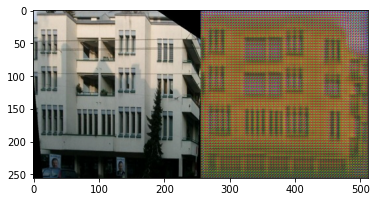

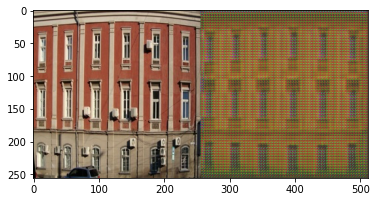

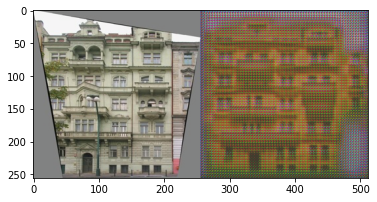

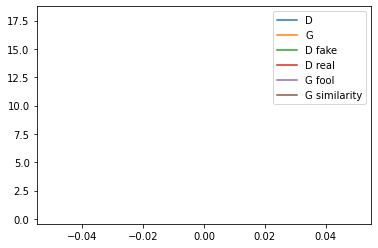

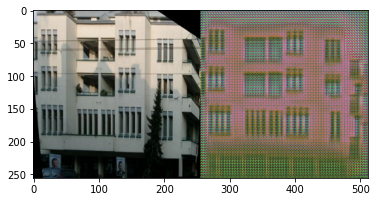

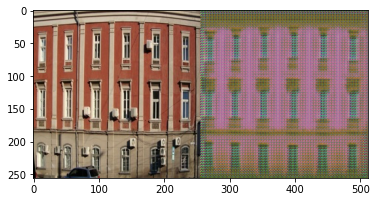

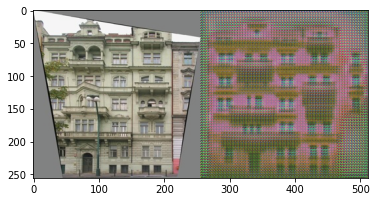

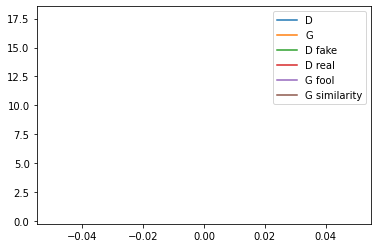

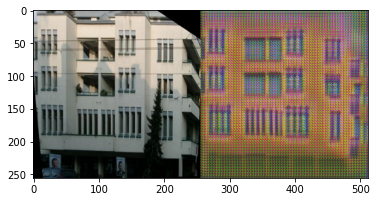

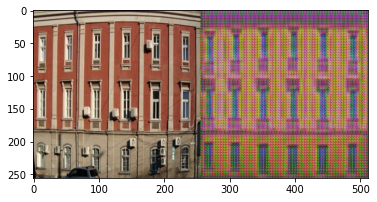

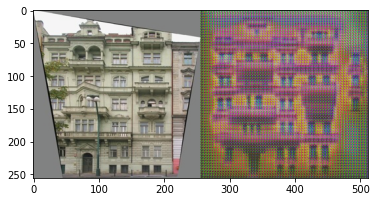

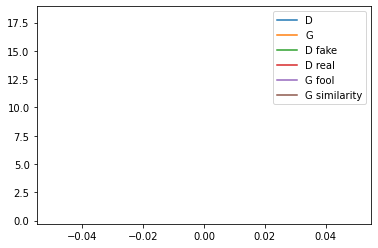

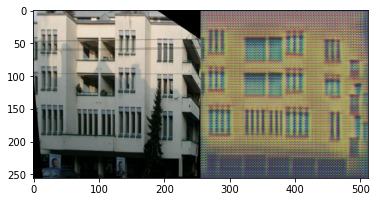

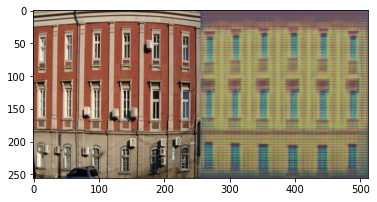

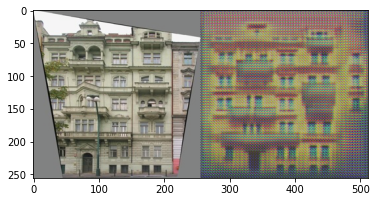

TOTAL NUMBER OF MODELS: 4
Step 0. Training model  disc t: 0.6; gen t: 0.0; mode: False!
trained epoch:  0
350.49986294428214
Step 1. Training model  disc t: 0.8; gen t: 0.0; mode: False!
trained epoch:  0
351.01916837827935
Step 2. Training model  disc t: 1.0; gen t: 0.0; mode: False!
trained epoch:  0
325.51228774879985
Step 3. Training model  disc t: 1.2; gen t: 0.0; mode: False!
trained epoch:  0
337.64941635499696
 disc t: 1.0; gen t: 0.0; mode: False gives FID: 325.51228774879985.
 disc t: 1.2; gen t: 0.0; mode: False gives FID: 337.64941635499696.
 disc t: 0.6; gen t: 0.0; mode: False gives FID: 350.49986294428214.
 disc t: 0.8; gen t: 0.0; mode: False gives FID: 351.01916837827935.


100%|██████████| 12/12 [00:02<00:00,  5.65it/s]


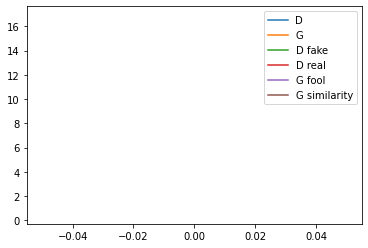

In [1390]:
#!g1.1
# Просто оставлю эту красоту - вроде только включил MLP
models_trained, names = train_several_models(models_trained, model_params_list, n_epochs=1, fid_lag=-1, show_img=True)

In [ ]:
#!g1.1
